Data is stored in drive. We install the torchxrayvision package to get the pretrained models. 

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')
!pip install torchxrayvision
'''About the data:
1 Folder with COVID images
1 Folder with Non COVID images

Train,Test,Val .txt for COVID
Train,Test,Val .txt for Non COVID
'''



Mounted at /content/gdrive
     |████████████████████████████████| 24.0MB 126kB/s 
     |████████████████████████████████| 1.9MB 47.5MB/s 


'About the data:\n1 Folder with COVID images\n1 Folder with Non COVID images\n\nTrain,Test,Val .txt for COVID\nTrain,Test,Val .txt for Non COVID\n'

In [8]:
!ls '/content/gdrive/MyDrive/My projects/data/covid_ct'

COVID  CT_COVID  CT_NonCOVID  NonCOVID


Now we import the relevant libraries

In [13]:
import os
import torch
import torchvision
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torchvision.transforms as Transforms
import torchvision.datasets as Datasets
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from PIL import Image
import torchxrayvision as xrv
from sklearn.metrics import roc_auc_score

Root directories of the data files

In [14]:
root_dir = '/content/gdrive/My Drive/My projects/data/covid_ct'
train_txt_covid = '/content/gdrive/My Drive/My projects/data/covid_ct/COVID/trainCT_COVID.txt'
train_txt_noncovid = '/content/gdrive/My Drive/My projects/data/covid_ct/NonCOVID/trainCT_NonCOVID.txt'
test_txt_covid = '/content/gdrive/My Drive/My projects/data/covid_ct/COVID/testCT_COVID.txt'
test_txt_noncovid = '/content/gdrive/My Drive/My projects/data/covid_ct/NonCOVID/testCT_NonCOVID.txt'

Now we define our transforms for data augmentation



In [15]:
train_transform = Transforms.Compose([
                                      Transforms.RandomHorizontalFlip(),
                                      Transforms.Resize(256),
                                      Transforms.RandomResizedCrop((224), scale=(0.5,1.0)),
                                      Transforms.ToTensor(),
                                      Transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

])

test_transform = Transforms.Compose([ Transforms.Resize(224),
                                      Transforms.CenterCrop(224),
                                      Transforms.ToTensor(),
                                      Transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

Now we define our dataset

In [16]:
#Function to get the last part of the path for each image ie to get all the items in the train.xtx and test.tct in covid and non-covid

def get_linebyline(txt_path):

  with open(txt_path) as f:
    lines = f.readlines()
  txt_data = [line.strip() for line in lines]
  return txt_data   


class COVID(Dataset):

  def __init__(self, root_dir, covid_txt , noncovid_txt , transform = None):
    self.root_dir = root_dir  #is dir with all folders
    self.txt_path = [covid_txt,noncovid_txt]
    self.transform = transform
    self.classes = ['CT_COVID' , 'CT_NonCOVID']
    self.num_class = len(self.classes)
    self.image_list = []

    #Now we need to get the images from the folder in our drive and populate images_list 
    # We want our classlist in the form [[imagepath,label],[imagepath,label],...] for each class
    for cclass in range (self.num_class):
      class_list = [[os.path.join(self.root_dir,self.classes[cclass],item),cclass]  for item in get_linebyline(self.txt_path[cclass])]
      self.image_list+= class_list

  def __len__(self):
    return len(self.image_list)    

  def __getitem__(self,index):

    if torch.is_tensor(index):
      index = index.tolist()

    label = self.image_list[index][1]
    image_path = self.image_list[index][0]
    #print(image_path)
    image = Image.open(image_path).convert('RGB')
    #print(image)

    if self.transform:
      image = self.transform(image)
    
    return image,label  

      

In [17]:
classes = ('CT_COVID', 'CT_NonCOVID')
batch_size = 30

Now we will define our train data and test data

In [18]:
train_data = COVID(root_dir = root_dir , covid_txt = train_txt_covid , noncovid_txt= train_txt_noncovid , transform = train_transform)
test_data = COVID(root_dir = root_dir , covid_txt = test_txt_covid , noncovid_txt= test_txt_noncovid , transform = test_transform)
train_loader =  DataLoader(dataset = train_data , batch_size = batch_size, shuffle = True )
test_loader =  DataLoader(dataset = test_data , batch_size = batch_size, shuffle = False,drop_last= True )

Now let us display the first few images

torch.Size([30, 3, 512, 512])
torch.Size([3, 512, 512])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

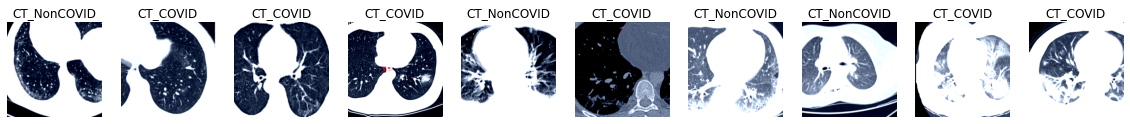

In [ ]:
train_iter = iter(train_loader)
images,labels = train_iter.next()
print(images.shape)
print(images[0].shape)

fig,axs = plt.subplots(nrows = 1 , ncols= 10 , figsize = (20,12))

for img,i in zip(images,range(10)):
  np_img = img.numpy()
  np_img = np.transpose(np_img,(1,2,0))
  np_img = np_img*(0.5,0.5,0.5) + (0.5,0.5,0.5) 
  axs[i].imshow(np_img)
  axs[i].axis('off')
  axs[i].set_title(classes[labels[i]])
plt.show()  

Now we will define our model. We will use a pretrained densenet model as our data set is too small. I have also implemented a pretrained ResNet model.

In [ ]:
class DenseNet(nn.Module):
  def __init__(self):
    super(DenseNet, self).__init__()
    self.dense_net = xrv.models.DenseNet(num_classes=2, in_channels=3)
    self.criterion = nn.CrossEntropyLoss()


  def forward(self, x):
    logits = self.dense_net(x)
    return logits

model = DenseNet()
modelname = 'DenseNet_medical'

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)


cuda:0


DenseNet(
  (dense_net): XRV-DenseNet
  (criterion): CrossEntropyLoss()
)

In [ ]:
class ResNet(nn.Module):
  def __init__(self):
    super(ResNet, self).__init__()
    self.res_net = xrv.models.ResNet
    self.criterion = nn.CrossEntropyLoss()


  def forward(self, x):
    logits = self.res_net(x)
    return logits

modelr = ResNet()
modelname = 'DenseNet_medical'

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
modelr.to(device)



cuda:0


ResNet(
  (res_net): XRV-ResNet-resnet50-res512-all
  (criterion): CrossEntropyLoss()
)

Now we define some hyper parameters

In [ ]:
criteria = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_of_epochs = 100
print(train_data.__len__())
print(test_data.__len__())


425
203


We will initialize some lists that will help us plot our graphs

In [19]:
train_loss_list = []
train_accuracy_list = []
test_loss_list=[]
test_accuracy_list = []
F1_list = []
AUC_list = []
votenum = 10
len_of_zeros = test_data.__len__()-(test_data.__len__()%batch_size)
print(len_of_zeros)
vote_pred = np.zeros(len_of_zeros)
vote_score = np.zeros(len_of_zeros)

180


Now we will define the training loop

In [ ]:
for epoch in range(num_of_epochs):

  train_loss = 0
  test_loss = 0
  total_trained = 0
  correct_trained = 0
  train_accuracy = 0
  total_tested = 0
  correct_tested = 0
  test_accuracy = 0 
  TP = 0
  TN = 0
  FN = 0
  FP = 0
  model.train()
  for images, labels in train_loader:
    images = images.to(device)
    labels = labels.to(device)
    train_pred = model(images)
    loss = criteria(train_pred,labels)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    train_loss+= loss.item()
    _, train_pred = torch.max(train_pred.data,1)
    total_trained += labels.size(0)
    correct_trained += train_pred.eq(labels).sum().item()   
  train_loss/= len(train_loader)
  train_accuracy = 100.*(correct_trained/total_trained)
  print("Epoch:",epoch+1,"Train loss: ", train_loss, "Train Accuracy:", train_accuracy)

  model.eval()
  with torch.no_grad():
   predlist=[]
   scorelist=[]
   targetlist=[]
   for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        test_pred = model(images)
        score = F.softmax(test_pred, dim=1)
        scorelist=np.append(scorelist, test_pred.cpu().numpy()[:,1])
        test_loss = criteria(test_pred,labels)
        _, test_pred = torch.max(test_pred.data,1)
        total1 += labels.size(0)
        targetcpu=labels.long().cpu().numpy()
        predlist=np.append(predlist, test_pred.cpu().numpy())
        targetlist=np.append(targetlist,targetcpu)
        total_tested += labels.size(0)
        correct_tested += test_pred.eq(labels).sum().item()
  test_loss/= len(test_loader)
  test_accuracy = 100.*(correct_tested/total_tested)
  print(f'Epoch: {epoch+1} , Test Loss: {test_loss} , Test Accuracy: {test_accuracy}' ,  )
  vote_pred = vote_pred + predlist 
  vote_score = vote_score + scorelist 

  if epoch % votenum == 0:
       
        # major vote
      vote_pred[vote_pred <= (votenum/2)] = 0
      vote_pred[vote_pred > (votenum/2)] = 1
      vote_score = vote_score/votenum
        
      print('vote_pred', vote_pred)
      print('targetlist', targetlist)
      TP = ((vote_pred == 1) & (targetlist == 1)).sum()
      TN = ((vote_pred == 0) & (targetlist == 0)).sum()
      FN = ((vote_pred == 0) & (targetlist == 1)).sum()
      FP = ((vote_pred == 1) & (targetlist == 0)).sum()
        
        
      print('TP=',TP,'TN=',TN,'FN=',FN,'FP=',FP)
      print('TP+FP',TP+FP)
      p = TP / (TP + FP)
      print('precision',p)
      p = TP / (TP + FP)
      r = TP / (TP + FN)
      print('recall',r)
      F1 = 2 * r * p / (r + p)
      acc = (TP + TN) / (TP + TN + FP + FN)
      print('F1',F1)
      print('acc',acc)
      AUC = roc_auc_score(targetlist, vote_score)
      print('AUC', AUC)
      vote_pred = np.zeros(len_of_zeros)
      vote_score = np.zeros(len_of_zeros)


      
#  test_loss /= total1
  test_loss_list.append(test_loss)
 # test_accuracy = (int(test_accuracy.data)/total1)*100.0
  test_accuracy_list.append(test_accuracy)
  train_loss_list.append(train_loss)
  train_accuracy_list.append(train_accuracy)
  F1_list.append(F1)
  AUC_list.append(AUC)

  


Epoch: 1 Train loss:  0.6717573841412862 Train Accuracy: 63.05882352941177
Epoch: 1 , Test Loss: 0.957476019859314 , Test Accuracy: 60.55555555555555
vote_pred [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
targetlist [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

Plotting the accuracy and loss graph

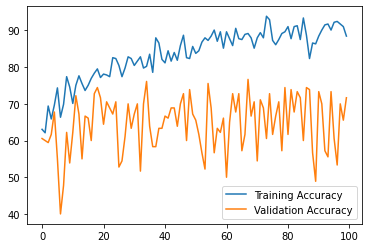

In [ ]:
#accuracy graph
plt.plot(train_accuracy_list, label ='Training Accuracy')
plt.plot(test_accuracy_list, label = 'Validation Accuracy')
plt.legend()

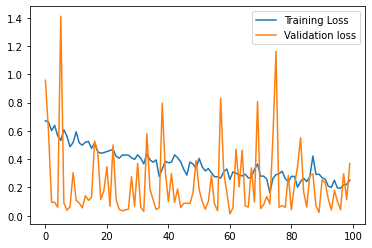

In [ ]:
#loss graph
plt.plot(train_loss_list, label ='Training Loss')
plt.plot(test_loss_list, label = 'Validation loss')
plt.legend()

In [ ]:
# Accuracy: 74.44%
#precision 0.686046511627907
#recall 0.7195121951219512
#F1 0.7023809523809523
#acc 0.7222222222222222
#AUC 0.8112244897959184